# Нейроэволюционный алгоритм

## 1. Подготовка данных для работы

### 1.1 Загружаем данные. Строки, не несущие информацию были удалены

In [1]:
import datatable as dt
data = dt.fread('cancer1.dt')
data

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
,▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪▪▪▪▪▪▪▪,▪,▪
0,bool_in=0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,real_in=9,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,bool_out=2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,real_out=0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,training_examples=350,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,validation_examples=175,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,test_examples=174,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,0.2,0.1,0.1,0.1,0.2,0.1,0.2,0.1,0.1,1,0
8,0.2,0.1,0.1,0.1,0.2,0.1,0.3,0.1,0.1,1,0


In [2]:
del data[0:7,:]

### 1.2 Преробразуем данные в формат pandas.DataFrame 

In [3]:
import pandas as pd
df = pd.DataFrame(data.to_pandas())
df

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10
0,0.2,0.1,0.1,0.1,0.2,0.1,0.2,0.1,0.1,True,False
1,0.2,0.1,0.1,0.1,0.2,0.1,0.3,0.1,0.1,True,False
2,0.5,0.1,0.1,0.1,0.2,0.1,0.2,0.1,0.1,True,False
3,0.5,0.4,0.6,0.8,0.4,0.1,0.8,1.0,0.1,False,True
4,0.5,0.3,0.3,0.1,0.2,0.1,0.2,0.1,0.1,True,False
...,...,...,...,...,...,...,...,...,...,...,...
694,0.5,0.1,0.2,0.1,0.2,0.1,0.1,0.1,0.1,True,False
695,0.7,0.5,0.6,1.0,0.5,1.0,0.7,0.9,0.4,False,True
696,0.6,1.0,1.0,1.0,0.8,1.0,0.7,1.0,0.7,False,True
697,0.5,0.7,1.0,1.0,0.5,1.0,1.0,1.0,0.1,False,True


### 1.3 Разделяем данные на входные и требуемые выходные значения

In [4]:
outputs = df[['C9','C10']] \
                    .iloc[:,0]\
                    .astype('int64')

outputs

0      1
1      1
2      1
3      0
4      1
      ..
694    1
695    0
696    0
697    0
698    1
Name: C9, Length: 699, dtype: int64

In [5]:
inputs = df.iloc[:, 0:9].copy().astype('float64')
inputs

,C0,C1,C2,C3,C4,C5,C6,C7,C8
0,0.2,0.1,0.1,0.1,0.2,0.1,0.2,0.1,0.1
1,0.2,0.1,0.1,0.1,0.2,0.1,0.3,0.1,0.1
2,0.5,0.1,0.1,0.1,0.2,0.1,0.2,0.1,0.1
3,0.5,0.4,0.6,0.8,0.4,0.1,0.8,1.0,0.1
4,0.5,0.3,0.3,0.1,0.2,0.1,0.2,0.1,0.1
...,...,...,...,...,...,...,...,...,...
694,0.5,0.1,0.2,0.1,0.2,0.1,0.1,0.1,0.1
695,0.7,0.5,0.6,1.0,0.5,1.0,0.7,0.9,0.4
696,0.6,1.0,1.0,1.0,0.8,1.0,0.7,1.0,0.7
697,0.5,0.7,1.0,1.0,0.5,1.0,1.0,1.0,0.1


### 1.4 Разбиваем выборку на тренировочную и тестовую

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, train_size = 0.8, random_state = 3)

In [7]:
import numpy as np
from NeuralNetwork import NeuralNetwork

## 2. Функции для работы нейроэволюционного алгоритма

### 2.1 Функция для прямого распространения в ансамбле ИНС.

In [8]:
def forward_prop_ensemble(ensemble,X):
  for count in range(len(ensemble)):
      ensemble[count].forward_propagation(X)


### 2.2 "Голосование" ансамбля ИНС (результат вероятность).

In [9]:
def ensemble_bagging_preds(ensemble):
  F = 0
  for count in range(len(ensemble)):
    F += np.sum(ensemble[count].neurons[-1])/len(ensemble)
  return F

### 2.3 "Голосование" ансамбля ИНС (дискретный результат - 0 или 1).

In [10]:
def ensemble_bagging(ensemble):
  F = 0
  for count in range(len(ensemble)):
    F += np.sum(ensemble[count].neurons[-1])/len(ensemble)
  if F>0.5:
    return 1
  else:
    return 0

### 2.4 Функция для оценивания точности обученного классификатора на тестовой выборке.

In [11]:
def ensemble_est(ensemble,X,y):
  # размер тестового датасета
  data_set_size = y.shape[0]
  # количество правильно классифицированных случаев
  correct = 0
  for i in range(data_set_size):
    for count in range(len(ensemble)):
      population[count].forward_propagation(X.iloc[i,:].to_numpy())
    prediction = ensemble_bagging(ensemble)
    if prediction == y.iloc[i]:
      correct +=1
  accuracy = correct/data_set_size*100
  print(f'accuracy: {accuracy}%')
  return accuracy

### 2.5 Скрещивание
###  $BLX-{\alpha}$ кроссинговер.

In [12]:
def crossbreeding(nn_parent_1, nn_parent_2, BLX_ALPHA):
    nn_child_1 = NeuralNetwork(nn_shape=nn_parent_1.nn_shape)
    nn_child_2 = NeuralNetwork(nn_shape=nn_parent_2.nn_shape)
    for i in range(len(nn_parent_1.weights)):
        for j in range(len(nn_parent_1.weights[i])):
            for k in range(len(nn_parent_1.weights[i][j])):
                c_min = np.minimum(nn_parent_1.weights[i][j][k], nn_parent_2.weights[i][j][k])
                c_max = np.maximum(nn_parent_1.weights[i][j][k], nn_parent_2.weights[i][j][k])
                delta_k = c_max - c_min
                nn_child_1.weights[i][j][k] = np.random.uniform(c_min - delta_k * BLX_ALPHA, c_max - delta_k * BLX_ALPHA)
                nn_child_2.weights[i][j][k] = np.random.uniform(c_min - delta_k * BLX_ALPHA, c_max - delta_k * BLX_ALPHA)

    return nn_child_1, nn_child_2

### 2.6 Селекция усечением

In [13]:
## Основной алгоритм# получаем двух особей усечением (лучшая половина популяции)
def cut_selection():
    individual_1 = 0
    individual_2 = 0
    while individual_1 == individual_2:
        individual_1 = np.random.randint(0,NN_POPULATION_COUNTS/2)
        individual_2 = np.random.randint(0,NN_POPULATION_COUNTS/2)
    return individual_1, individual_2

### 2.6.1 Удаление наибольших значений ошибок

In [14]:
def del_largest_errors(sort_indx):
    if sort_indx[-1]>sort_indx[-2]:
        population.remove(population[sort_indx[-1]])
        population.remove(population[sort_indx[-2]])
    else:
        population.remove(population[sort_indx[-2]])
        population.remove(population[sort_indx[-1]])

### 2.7 Мутация

In [15]:
def gauss_mutation(population, MUTATION_COUNTS):
    for mut_count in range(MUTATION_COUNTS):
        mut = np.random.randint(0,len(population))
        population[mut].mutation()

In [16]:
def calculate_error_f(population, error_f, CORRELATION_CONSTANT, F, d, N, p):
    for count in range(len(population)):
      for count_p in range(len(population)):
        if count_p != count:
          p[count] += (population[count].neurons[-1]-F)*(population[count_p].neurons[-1]-F)
      error_f[count]+=1/N/2*(population[count].neurons[-1]-d)**2+1/N*CORRELATION_CONSTANT*p[count]

## 3. Гиперпараметры для настройки алгоритма

In [17]:
# количество циклов эволюции
EPOCHS = 500
NN_SHAPE = (9,6,6,1)
NN_POPULATION_COUNTS = 10
BLX_ALPHA = 0.5
MUTATION_COUNTS = 2
# Обучающая выборка
N = 10
# константа корреляции
CORRELATION_CONSTANT = 0.4

## 4. Основной алгоритм

### 4.1 Инициализация начальной популяции

In [18]:
# формирование начальной популяции
population = []
for count in range(NN_POPULATION_COUNTS):
  neural_network = NeuralNetwork(nn_shape=NN_SHAPE)
  population.append(neural_network)

model_accuracy_array = []
epochs_array = []
error_f = np.zeros(len(population))

### 4.2 Основной цикл алгоритма

In [19]:
for epoch in range(EPOCHS):
    sort_indx = error_f.argsort() # индексы отсортированных элементов

    individual_1, individual_2 = cut_selection()

    # Кроссинговер BLX-a. Получаем двух потомков от двух родителей
    nn_child_1, nn_child_2 = crossbreeding(population[sort_indx[individual_1]],
                                         population[sort_indx[individual_2]],BLX_ALPHA)


    # Удаляем особи с наибольшим значением функции ошибки
    del_largest_errors(sort_indx)

    population.append(nn_child_1)
    population.append(nn_child_2)

    gauss_mutation(population, MUTATION_COUNTS)
    # Обнулим массив значений функции ошибок
    error_f[:]=0

    # Цикл обучения
    for learning_cycle in range(N):
        #выбираем случайный индекс элемент тренировочного датасета
        df_index = np.random.randint(0,X_train.shape[0])
        # входные данные
        piece_of_data = X_train.iloc[df_index,:].to_numpy()
        # желаемый отклик
        d = y_train.iloc[df_index]
        p = np.zeros_like(error_f)
        # прямое распространение для всей популяции
        forward_prop_ensemble(population,piece_of_data)
        # общий вывод популяции
        F = ensemble_bagging_preds(population)
        # расчёт функции корреляционного штрафа
        calculate_error_f(population, error_f, CORRELATION_CONSTANT, F, d, N, p)
    
    
    if epoch%5==0:
        epochs_array.append(epoch)
        print(f'epoch: {epoch}')
        model_accuracy_array.append(ensemble_est(population,X_test,y_test))


epoch: 0
accuracy: 34.285714285714285%
epoch: 5
accuracy: 34.285714285714285%
epoch: 10
accuracy: 34.285714285714285%
epoch: 15
accuracy: 34.285714285714285%
epoch: 20
accuracy: 34.285714285714285%
epoch: 25
accuracy: 34.285714285714285%
epoch: 30
accuracy: 34.285714285714285%
epoch: 35
accuracy: 34.285714285714285%
epoch: 40
accuracy: 34.285714285714285%
epoch: 45
accuracy: 60.71428571428571%
epoch: 50
accuracy: 96.42857142857143%
epoch: 55
accuracy: 34.285714285714285%
epoch: 60
accuracy: 34.285714285714285%
epoch: 65
accuracy: 34.285714285714285%
epoch: 70
accuracy: 34.285714285714285%
epoch: 75
accuracy: 34.285714285714285%
epoch: 80
accuracy: 34.285714285714285%
epoch: 85
accuracy: 43.57142857142857%
epoch: 90
accuracy: 45.714285714285715%
epoch: 95
accuracy: 59.285714285714285%
epoch: 100
accuracy: 92.14285714285714%
epoch: 105
accuracy: 90.71428571428571%
epoch: 110
accuracy: 90.71428571428571%
epoch: 115
accuracy: 91.42857142857143%
epoch: 120
accuracy: 89.28571428571429%
epoch

## 5. Анализ
#### 5.1 Далее оценим точность классификатора на тестовой выборке.

In [20]:
ensemble_est(population,X_test,y_test)

accuracy: 94.28571428571428%


94.28571428571428

#### 5.2 График обучения

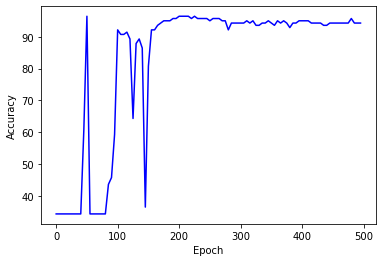

In [21]:
import matplotlib.pyplot as plt

plt.plot(epochs_array, model_accuracy_array, c='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#### 5.3 Демонстрация вероятностного вывода.

In [22]:
df_index = np.random.randint(0,X_test.shape[0])
piece_of_data = X_test.iloc[df_index,:].to_numpy()
d = y_test.iloc[df_index]
for count in range(len(population)):
  population[count].forward_propagation(piece_of_data)
F = ensemble_bagging_preds(population)
print(d)
print(F)

1
0.0014036738611993007


#### 5.4 Функция для вывода весов связей в отдельный файл.

In [23]:
def save_weights(ensemble):
  file = open('NN_ensemble_structure.txt','w')
  for nn in range(len(ensemble)):
    file.write('\n########################\n')
    for i in range(len(ensemble[nn].weights)):
      for j in range(len(ensemble[nn].weights[i])):
        for k in range(len(ensemble[nn].weights[i][j])):
          file.write(str(ensemble[nn].weights[i][j][k])+' ')
        file.write('\n')
  file.close()


In [24]:
save_weights(population)

#### 5.5 Функция для записи весов смещения.

In [25]:
def save_bias(ensemble):
  file = open('NN_ensemble_bias.txt','w')
  for nn in range(len(ensemble)):
    file.write('\n########################\n')
    for i in range(len(ensemble[nn].biases)):
      for j in range(len(ensemble[nn].biases[i])):
        file.write(str(ensemble[nn].biases[i][j])+' ')
      file.write('\n')
  file.close()

In [26]:
save_bias(population)